# Laboratorio 9: Percepción Remota Aplicada

## Álvaro Paredes (alvaro.paredes@dataobservatory.net) | Javier Lopatin (javier.lopatin@uai.cl)

En este práctico vamos a ver cómo utilizar Jupyter Notebooks con Kernel de Python para realizar una clasificación por medio de RandomForest

Primero, instalaremos las librerias correspondientes:


In [11]:
%%capture
# Installations
!apt install gdal-bin python-gdal python3-gdal 
!pip install geopandas
!pip install xarray rasterio rioxarray earthpy
!pip install sklearn numpy
!pip install yellowbrick

In [12]:
# cargamos las librerias en el sistema
import xarray as xr
import rioxarray as riox
import pandas as pd
import geopandas as gpd
import numpy as np
import glob, os
import matplotlib.pyplot as plt
import earthpy.plot as ep

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split#, RandomizedSearchCV
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import LabelEncoder

from yellowbrick.classifier import ConfusionMatrix, ClassPredictionError
from yellowbrick.model_selection import FeatureImportances

In [13]:
# función para cargar un raster a la memoria del sistema
def rasterio_open(f):
    return riox.open_rasterio(f)

## Cargar Datos de tablas





In [14]:
%%capture
!wget https://raw.githubusercontent.com/alvaroparedesl/percepcion_remota/main/Data/Lab09/All_Bands_PNLC.tif
!wget https://raw.githubusercontent.com/alvaroparedesl/percepcion_remota/main/Data/Lab09/datos_clases.csv

In [15]:
data = pd.read_csv('datos_clases.csv')
data.head()

,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,...,MVC_verano,MVC_otono,MVC_primavera,Textura_medB7,Textura_medB5,Textura_medB8,Elevacion,Pendiente,Orientacion,clases
0,0.116538,0.097204,0.084575,0.069557,0.077795,0.065860,0.051047,0.071272,0.001001,301.975769,...,0.171810,0.138893,0.176980,0.058077,0.040518,0.042207,203.519440,2.195822,166.920486,WT
1,0.114060,0.094510,0.084763,0.063313,0.043447,0.019439,0.011922,0.075896,0.001025,297.871368,...,0.035606,0.080876,0.102556,0.039448,0.080102,0.022672,338.000000,1.179771,98.910927,WT
2,0.110376,0.088469,0.077436,0.051380,0.026967,0.010360,0.007063,0.065595,0.001079,295.699005,...,0.003056,0.062011,0.062011,0.050660,0.084762,0.015890,337.723572,7.378914,142.959625,WT
3,0.100265,0.078912,0.062572,0.044765,0.145465,0.082202,0.049481,0.057622,0.001146,293.067749,...,0.556129,0.375411,0.556129,0.010979,0.016041,0.005614,1134.411011,29.756573,241.256683,BE
4,0.103709,0.081290,0.058453,0.040216,0.134028,0.091544,0.052984,0.052199,0.000990,295.894257,...,0.555121,0.238727,0.555121,0.037006,0.053948,0.014165,602.251831,21.970224,253.403412,BE


In [16]:
# clases de uso de suelo
print(data.clases.unique())
print(len(data.clases.unique()))

['WT' 'BE' 'CU' 'HU' 'ME' 'MX' 'PP' 'BC' 'RC' 'SD' 'UR']
11


In [17]:
# cuantas observaciones hay por clase?
group = data.groupby("clases")
group.count()
# eliminemos la clase WT que tiene sólo 3 observaciones

,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,...,Cte,MVC_verano,MVC_otono,MVC_primavera,Textura_medB7,Textura_medB5,Textura_medB8,Elevacion,Pendiente,Orientacion
clases,,,,,,,,,,,,,,,,,,,,,
BC,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70
BE,265,265,265,265,265,265,265,265,265,265,...,265,265,265,265,265,265,265,265,265,265
CU,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
HU,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
ME,231,231,231,231,231,231,231,231,231,231,...,231,231,231,231,231,231,231,231,231,231
MX,84,84,84,84,84,84,84,84,84,84,...,84,84,84,84,84,84,84,84,84,84
PP,59,59,59,59,59,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,59
RC,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
SD,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42


In [19]:
data2 = data[data.clases != "WT"]
data2.clases

3      BE
4      BE
5      BE
6      BE
7      BE
       ..
868    UR
869    UR
870    UR
871    UR
872    UR
Name: clases, Length: 870, dtype: object

## Ajuste del modelo

In [20]:
# se pueden cambiar los labels de str a int
# se puede hacer antes del modelameinto, aunque no debería cambiar los resultados. 
le = LabelEncoder()
le.fit(data2.clases)
Y = le.transform(data2.clases)
labels = pd.DataFrame({'Name': data2.clases, 'Code': Y}).drop_duplicates().reset_index(drop=True).sort_values('Code')

# predictores
X = data2.iloc[:,0:23]

In [21]:
# separar observaciones en un set de datos de entrenamiento y validacion
y_train, y_test, X_train, X_test = train_test_split(Y, X, test_size=1/3, stratify=Y, random_state=3451)
print(len(y_train))
print(len(y_test))

580
290


In [22]:
# datos X de validación
X_test.head()

,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,...,Cte,MVC_verano,MVC_otono,MVC_primavera,Textura_medB7,Textura_medB5,Textura_medB8,Elevacion,Pendiente,Orientacion
589,0.122891,0.110129,0.106687,0.106121,0.223515,0.184666,0.133651,0.107339,0.002012,299.799622,...,0.931260,0.346575,0.348778,0.349207,0.011120,0.015381,0.010301,1568.577515,33.384823,326.962006
830,0.138435,0.133562,0.155991,0.190914,0.301139,0.328055,0.244708,0.168113,0.001473,302.192505,...,0.950792,0.241254,0.223305,0.241808,0.054739,0.027198,0.042367,1184.704956,7.737138,125.582077
743,0.097043,0.077443,0.066231,0.046365,0.217745,0.117824,0.055319,0.055900,0.001638,290.950775,...,0.071043,0.661318,0.437968,0.661318,0.005644,0.023444,0.002958,1550.622070,33.114132,221.246323
849,0.161066,0.148157,0.146300,0.160623,0.258228,0.256268,0.205390,0.167548,0.001345,304.430847,...,0.984428,0.226332,0.197220,0.226332,0.028826,0.018537,0.021523,172.001465,0.973981,202.582031
127,0.101639,0.078830,0.054786,0.035541,0.133583,0.059049,0.028964,0.047893,0.001015,292.850525,...,0.364001,0.642452,0.387880,0.642452,0.013732,0.018959,0.005357,762.322571,28.028389,198.490356


In [23]:
# datos y de validación
y_test

array([6, 8, 0, 9, 1, 4, 0, 1, 1, 1, 4, 3, 1, 5, 4, 0, 8, 6, 8, 7, 4, 1,
       1, 1, 1, 5, 3, 4, 1, 1, 0, 4, 4, 4, 9, 7, 1, 0, 4, 9, 3, 8, 1, 4,
       5, 9, 0, 6, 8, 1, 8, 4, 7, 1, 1, 1, 1, 4, 4, 3, 3, 1, 6, 0, 1, 4,
       4, 5, 9, 0, 8, 4, 1, 4, 9, 5, 1, 1, 2, 5, 0, 4, 1, 9, 6, 1, 1, 4,
       4, 0, 2, 5, 4, 0, 4, 5, 4, 4, 9, 4, 4, 4, 9, 4, 3, 6, 4, 4, 3, 4,
       1, 4, 1, 1, 1, 8, 4, 4, 1, 1, 1, 5, 3, 6, 1, 5, 1, 5, 0, 6, 1, 4,
       6, 1, 1, 1, 4, 1, 1, 5, 8, 5, 0, 7, 4, 4, 1, 1, 1, 4, 4, 3, 0, 6,
       1, 1, 4, 4, 8, 1, 9, 4, 1, 4, 4, 4, 1, 1, 3, 1, 1, 1, 3, 1, 1, 6,
       1, 6, 8, 3, 6, 7, 1, 1, 6, 4, 4, 6, 0, 5, 5, 4, 1, 1, 0, 0, 1, 3,
       6, 6, 5, 5, 7, 6, 1, 4, 6, 4, 1, 2, 7, 4, 1, 7, 4, 4, 1, 1, 4, 8,
       4, 1, 4, 7, 1, 4, 4, 6, 0, 5, 9, 1, 4, 4, 5, 5, 3, 4, 1, 1, 1, 4,
       5, 1, 4, 4, 0, 4, 4, 1, 5, 0, 1, 5, 5, 1, 4, 4, 8, 3, 4, 5, 0, 1,
       0, 1, 4, 1, 4, 4, 0, 1, 1, 1, 4, 1, 5, 4, 1, 4, 1, 4, 7, 1, 5, 1,
       0, 8, 5, 1])

In [ ]:
# parametros para hacer tuning
# no vamos acorres esto en el práctico,ya que toma bastante tiempo en Colab.
'''
# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 5)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': True}
print(random_grid)
'''

In [ ]:
'''
# entrenar un clasificador Random Forest con parameter tuning de KFold
model = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
RF = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

RF.fit(X_train, y_train)
RF.best_params_
'''

In [32]:
from pandas.core.common import random_state
# ajustar modelo con mejores parámetros encontrados de antemano
model = RandomForestClassifier(
    bootstrap = True,
    max_depth = 85,
    max_features = 'auto',
    min_samples_leaf = 1,
    min_samples_split = 2,
    n_estimators = 1800,
    random_state=100)

# se pone .values en X_train para entrenar con array y no con DataFrame
model.fit(X_train, y_train) 

# ajustes en entrenamiento
pred_train = model.predict(X_train)
# indice Kappa
cohen_kappa_score(y_train, pred_train)

# sobreajustado?

0.9936021884927638

Opcionalmente se puede guardar el modelo entrenado para ser usado después.

Corriendo el código siguiente se puede guardar el modelo en formato binary.joblib:

```python
dump(model, 'ml_model.joblib')
```
Para cargar nuevamente el modelo al sistema: 

```python
from joblib import load
ml_model = 'ml_model.joblib'
model = load(ml_model)
```

## Evaluación del modelo

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


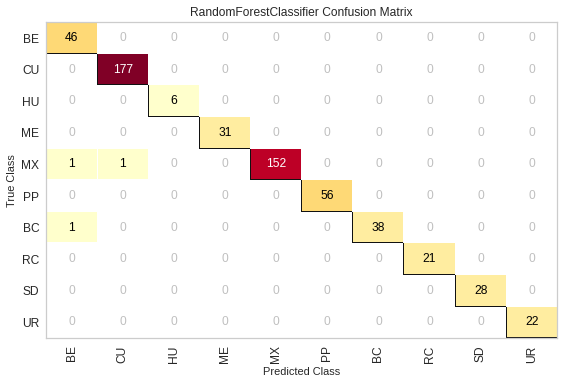

In [25]:
# matriz de confusion usando el método de yellowbrick
cm = ConfusionMatrix(model, classes=data2.clases.unique())
cm.fit(X_train, y_train)
cm.score(X_train, y_train)
cm.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


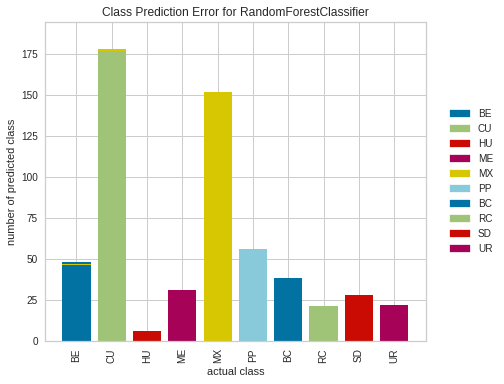

In [26]:
# otra forma de ver donde estan los errores
visualizer = ClassPredictionError(model, classes=data2.clases.unique())
visualizer.fit(X_train, y_train)
visualizer.score(X_train, y_train)
visualizer.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


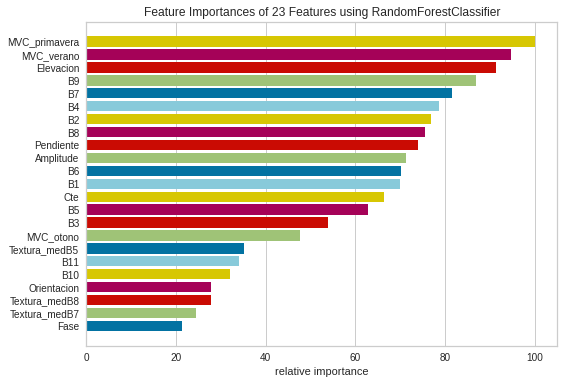

In [27]:
#variable importance
visualizer = FeatureImportances(model)
visualizer.fit(X_train, y_train)
visualizer.show()

## Actividad: repita ejercicion de visualización de resultados con los datos de validación (test) ¿cuánta diferencia de ajuste hay?

## Respuestas

In [33]:
# ajustes en entrenamiento
pred_test = model.predict(X_test)
# indice Kappa
cohen_kappa_score(y_test, pred_test)


0.7456291627021883

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


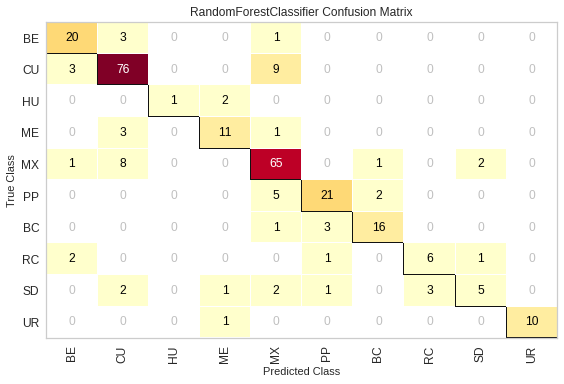

In [34]:
cm = ConfusionMatrix(model, classes=data2.clases.unique())
cm.fit(X_test, y_test)
cm.score(X_test, y_test)
cm.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


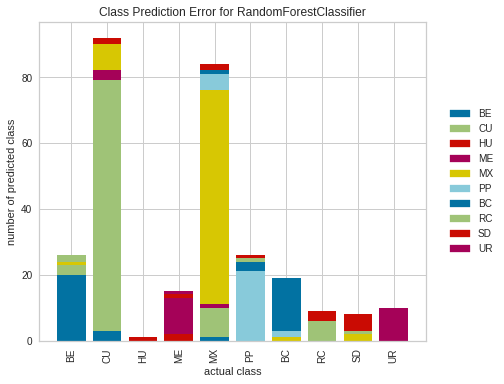

In [36]:
visualizer = ClassPredictionError(model, classes=data2.clases.unique())
visualizer.fit(X_test, y_test)
visualizer.score(X_test, y_test)
visualizer.show()

### Cargar datos rasterizados y predecir valores en raster

In [37]:
img = rasterio_open('All_Bands_PNLC.tif').squeeze(drop=True)
img

<xarray.DataArray (band: 23, y: 588, x: 744)>
[10061856 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
  * x            (x) float64 -71.18 -71.18 -71.18 ... -70.98 -70.98 -70.98
  * y            (y) float64 -32.89 -32.89 -32.89 ... -33.04 -33.04 -33.04
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

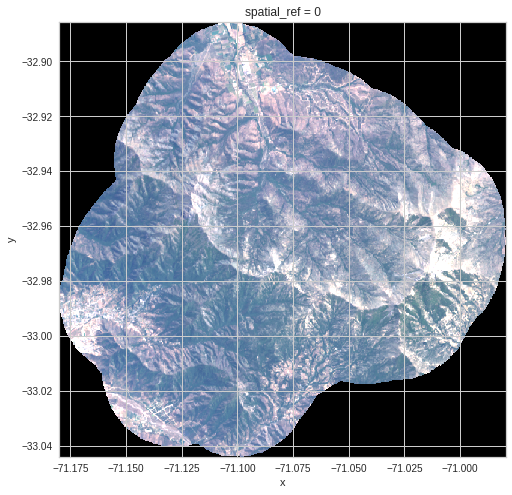

In [38]:
img[[3, 2, 1], :, :].plot.imshow(
    robust=True, figsize=(8, 8)
)

### Es fundamental es transformar el 3D array a 2D => debe tener las mismas columnas y en el mismo orden que el DataFrame que usaron para entrenar el algoritmo. 

Para esto se multiplican las filas y las columnas para transformar toda esa info a filas, y las bandas pasan a ser la columnas (mismo formato que en la tabla de datos que usamos para entrenar el algoritmo!)

In [39]:
img_flat = img.stack(z=('y','x'))
img_flat

<xarray.DataArray (band: 23, z: 437472)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
    spatial_ref  int64 0
  * z            (z) MultiIndex
  - y            (z) float64 -32.89 -32.89 -32.89 ... -33.04 -33.04 -33.04
  - x            (z) float64 -71.18 -71.18 -71.18 ... -70.98 -70.98 -70.98
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [40]:
# ahora usamos transpose para dejar las bandas como columnas y no como filas
# ahora si esta en el mismo formato de se uso para entrenar el algoritmo
img_flat = img_flat.transpose('z', 'band')
img_flat

<xarray.DataArray (z: 437472, band: 23)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
    spatial_ref  int64 0
  * z            (z) MultiIndex
  - y            (z) float64 -32.89 -32.89 -32.89 ... -33.04 -33.04 -33.04
  - x            (z) float64 -71.18 -71.18 -71.18 ... -70.98 -70.98 -70.98
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [41]:
# convertir NaNs a ceros
img_flat.values = np.nan_to_num(img_flat.values) 

# predecir en datos de mapa
map_pred = model.predict(img_flat.values)
map_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([1, 1, 1, ..., 1, 1, 1])

In [42]:
# hacemoms un template con la forma del Xarray para una banda
template = img_flat[:, 0]
# asignamos los datos predichos
output_array = template.copy(data=map_pred)
output_array
# ahora hay solu una dimensión, yaque el mapa de clases tiene una sóla banda

<xarray.DataArray (z: 437472)>
array([1, 1, 1, ..., 1, 1, 1])
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * z            (z) MultiIndex
  - y            (z) float64 -32.89 -32.89 -32.89 ... -33.04 -33.04 -33.04
  - x            (z) float64 -71.18 -71.18 -71.18 ... -70.98 -70.98 -70.98
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [43]:
# usamos unstack para volver a la forma inicial
unstacked = output_array.unstack()
unstacked

<xarray.DataArray (y: 588, x: 744)>
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * y            (y) float64 -32.89 -32.89 -32.89 ... -33.04 -33.04 -33.04
  * x            (x) float64 -71.18 -71.18 -71.18 ... -70.98 -70.98 -70.98
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

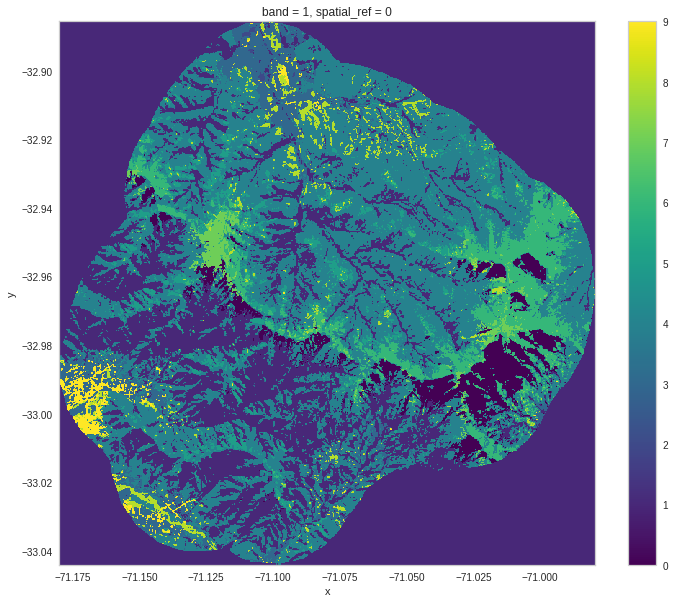

In [44]:
unstacked.plot(figsize=(12, 10))

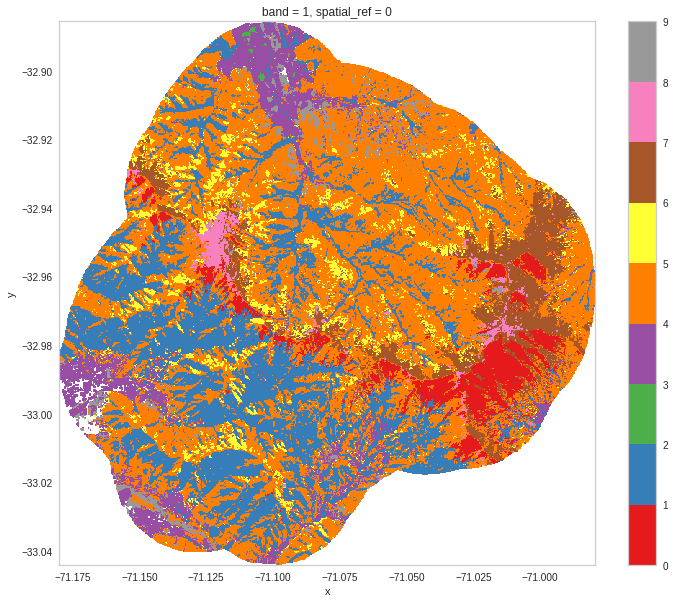

In [ ]:
# map.astype(np.float16)
unstacked.values = xr.where(img.values[0,:,:] > 0, unstacked, np.nan)
unstacked.plot(levels=10, colors='Set1', figsize=(12, 10))

In [ ]:
labels.T

,6,0,1,2,3,4,5,7,8,9
Name,BC,BE,CU,HU,ME,MX,PP,RC,SD,UR
Code,0,1,2,3,4,5,6,7,8,9


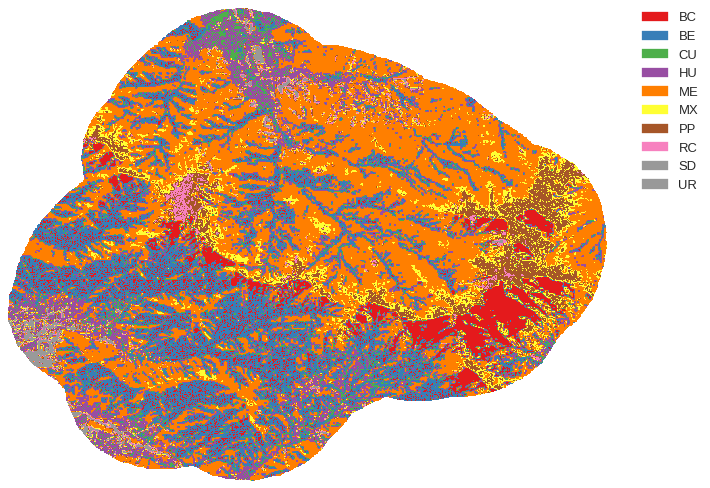

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(unstacked, cmap='Set1')
ep.draw_legend(im, titles=labels.Name.tolist())
plt.grid(b=None)
plt.axis('off')
plt.tight_layout()


dtype('int64')